In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools
import random as python_random
from keras.initializers import GlorotUniform
from keras.initializers import Orthogonal

np.random.seed(42)
tf.random.set_seed(42)
python_random.seed(42)

2024-06-05 00:47:00.399102: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-05 00:47:00.419209: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 00:47:00.419225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 00:47:00.419788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 00:47:00.423283: I tensorflow/core/platform/cpu_feature_guar

In [3]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

In [4]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    # print("data", data[:15])
    # print("target", target[:15])
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [5]:
def modify_data(data):
    result = None
    # print(data)

    # copy LMCADY_acu_5d_log into a new column ACU_5D and shift it by 5 days
    data['ACU_5D'] = data['LMCADY_acu_5d_log']
    data['ACU_5D'] = data['ACU_5D'].shift(5)

    data['ACU_4D'] = data['LMCADY'].rolling(window=4).sum()
    data['ACU_3D'] = data['LMCADY'].rolling(window=3).sum()
    data['ACU_2D'] = data['LMCADY'].rolling(window=2).sum()

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)

    result = data
    # print(result.head(10))
    return result

In [6]:
def prepare_data(df, target_column, n_steps, feature_list = []):

    df = modify_data(df)
    df.to_csv('../output/modified_data.csv', index=False)

    features = df.drop(columns=[target_column, 'LMCADY_std_5d_log'])
    features = features.drop(columns = ['Date'])
    features = features[feature_list]
    print("Features utilizados:",features.columns)

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    X, y = create_sequences(features_scaled, target, n_steps)
    # for i in range(15):
    #     print(X[i][0][0], y[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle = False)

    return X_train, X_test, y_train, y_test

In [7]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [8]:
def build_model(input_shape, md_prm: dict):

    model = Sequential()
    initializer = GlorotUniform(seed=42)

    model.add(LSTM(md_prm['lstm_units'], return_sequences=True, input_shape=input_shape, kernel_initializer=initializer))
    model.add(LSTM(md_prm['lstm_units'], kernel_initializer=initializer))
    model.add(Dense(1, kernel_initializer=initializer))

    model.compile(optimizer=Adam(learning_rate = 0.0001), loss='mean_squared_error', metrics=[rmse])
    return model

In [9]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):

    early_stopping = EarlyStopping(
        monitor             ='val_loss',
        patience            =50,
        verbose             =1,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs              =epochs,
        batch_size          =batch_size,
        verbose             =verbose,
        callbacks           =[early_stopping],
        validation_split    =0.05
    )

    return history

In [10]:
def evaluate_model(model, X_test, y_test):
    return model.evaluate(X_test, y_test)

In [24]:
def plot_predictions(y_true, y_pred, n = -1, title="Prediction vs Actual Data", markersize=3, rmse = None):

    if n != -1:
        n = min(n, len(y_true), len(y_pred))

        y_true = y_true[-n:]
        y_pred = y_pred[-n:]

    plt.figure(figsize=(18, 2.5))
    plt.plot(y_true, label='Actual Values'   , marker='o', linestyle='-' , markersize=markersize)
    plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', markersize=markersize)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)

    # add rmse as a xhline in the plot if it is not None
    if rmse is not None:
        plt.axhline(y= rmse, color='green', linestyle='--', linewidth=0.7)
        plt.axhline(y=-rmse, color='green', linestyle='--', linewidth=0.7)

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [12]:
def trend_accuracy(y_true, y_pred):
    trend_up_true = 0
    trend_down_true = 0
    trend_up_pred = 0
    trend_down_pred = 0

    for j in range(len(y_true)-1):
        if y_true[j] > 0.0:
            trend_up_pred += 1
            if y_pred[j] > 0.0:
                trend_up_true += 1
        if y_true[j] < 0.0:
            trend_down_pred += 1
            if y_pred[j] < 0.0:
                trend_down_true += 1

    trend_true = trend_up_true + trend_down_true
    trend_pred = trend_up_pred + trend_down_pred

    trend_up_accuracy = trend_up_true/trend_up_pred
    trend_down_accuracy = trend_down_true/trend_down_pred
    trend_accuracy = trend_true/trend_pred

    return trend_accuracy, trend_up_accuracy, trend_down_accuracy

In [15]:
n_steps_options     = [40 ,60,120]
batch_size_options  = [256,128,64]
epochs_options      = [300]

lstm_units_options  = [25,75]
activation_options  = ['relu']
dropout_options     = [.15]
num_layers_options  = [2]

# # caso seleccionado
# n_steps_options     = [120]
# batch_size_options  = [256]
# epochs_options      = [300]

# lstm_units_options  = [25]
# activation_options  = ['relu']
# dropout_options     = [.15]
# num_layers_options  = [2]



# variable_options = ['LMCADS03','LMCADY','SPX','MXWD','XAU','XAG','ACU_5D','ACU_4D','ACU_3D','ACU_2D']
# modified_lists = [variable_options[:i] + variable_options[i+1:] for i in range(len(variable_options))]
# print(modified_lists)
modified_lists = [['LMCADS03','LMCADY','SPX','MXWD','XAG','XAU','ACU_5D','ACU_4D','ACU_3D','ACU_2D']]

# combinations
model_params_combinations = list(itertools.product(
    n_steps_options     ,
    lstm_units_options,
    activation_options,
    dropout_options,
    num_layers_options,
    batch_size_options,
    epochs_options,
    modified_lists
))
target_column = 'LMCADY_acu_5d_log'

In [16]:
n_iterations = len(model_params_combinations)
print("Total iterations: {}".format(n_iterations))

Total iterations: 18


In [17]:
def run_model_iterations():
    top_results = []
    i = 1
    for params in model_params_combinations:
        n_steps, lstm_units, activation, dropout, num_layers, batch_size, epochs, var_options = params
        try:

            # data load
            df = load_data("../input/copper_log_returns_5d_final.csv")
            print("\nIteration {}/{}".format(i, n_iterations))
            print("Params: n_steps: {}, lstm_units: {}, activation: {}, dropout: {}, num_layers: {}".format(
                n_steps, lstm_units, activation, dropout, num_layers)
            )

            print("Train : batch> {}".format(batch_size))

            # data preparation
            # print("Variables used: {}".format(var_options))
            X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps, var_options)

            # build model
            model_params = {
                'lstm_units': lstm_units,
                'activation': activation,
                'dropout'   : dropout,
                'num_layers': num_layers
            }
            input_shape = (X_train.shape[1], X_train.shape[2])
            print("Input shape: {}".format(input_shape))
            model = build_model(input_shape, model_params)
            print(model.summary())

            # model train
            if True:
                history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

                # model evaluation
                y_pred      = model.predict(X_test)
                rmse_score  = math.sqrt(mean_squared_error(y_test, y_pred))
                std_dev     = np.std(y_test)

                print("Pred std dev: {:.6f}, test std dev: {:.6f}".format(np.std(y_pred), std_dev))

                if rmse_score < std_dev:
                    diff = rmse_score - std_dev + abs(np.std(y_pred) - std_dev)/4.0
                else:
                    diff = (rmse_score - std_dev) + abs(np.std(y_pred) - std_dev)/2.0

                # diff = (rmse_score - std_dev) + abs(np.std(y_pred) - std_dev)/2.0
                tren_acc, trend_up, trend_down = trend_accuracy(y_test, y_pred)
                result = {
                    'n_steps'   : n_steps,
                    'lstm_units': lstm_units,
                    'activation': activation,
                    'dropout'   : dropout,
                    'num_layers': num_layers,
                    'batch_size': batch_size,
                    'epochs'    : epochs,
                    'rmse'      : rmse_score,
                    'std_dev'   : std_dev,
                    'diff'      : diff,
                    'predictions': y_pred,
                    'true_values': y_test,
                    'feature_list': var_options,
                    'tr_ac': tren_acc,
                    'tr_up': trend_up,
                    'tr_down': trend_down
                }

                # print("RMSE: {:.6f}, STD_DEV: {:.6f}, DIFF: {:.6f}".format(rmse_score, std_dev, diff))
                print("RMSE: {:.6f}, STD_DEV: {:.6f}, STD_PRD: {:.6f}, OBJDIFF: {:.6f}, RDIFF: {:.6f}".format(rmse_score, std_dev, np.std(y_pred), diff, (rmse_score - std_dev)))

                print("Trend: {:.2f}, Up: {:.2f}, Down: {:.2f}".format(tren_acc*100, trend_up*100, trend_down*100))

                top_results.append(result)
                top_results = sorted(top_results, key=lambda x: x['diff'])
                plot_predictions(result['true_values'], result['predictions'], -1, title="It. {}".format(i))

            print("Completed Iteration {}/{}".format(i, n_iterations))
        except Exception as ex:
            print(f"An error occurred: {ex}. Skipping this combination.")
        i += 1
    return top_results


Iteration 1/18
Params: n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)


2024-06-05 00:47:31.112307: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-05 00:47:31.130401: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-05 00:47:31.130512: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 25)            3600      
                                                                 
 lstm_1 (LSTM)               (None, 25)                5100      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


2024-06-05 00:47:34.045535: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-06-05 00:47:34.376490: I external/local_xla/xla/service/service.cc:168] XLA service 0x7b338421bb60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-05 00:47:34.376505: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-06-05 00:47:34.379314: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717566454.429108  564959 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping
9/9 [==============================] - 0s 2ms/step
Pred std dev: 0.007593, test std dev: 0.021968
RMSE: 0.021396, STD_DEV: 0.021968, DIFF: 0.003022
Trend: 59.27, Up: 76.71, Down: 39.53


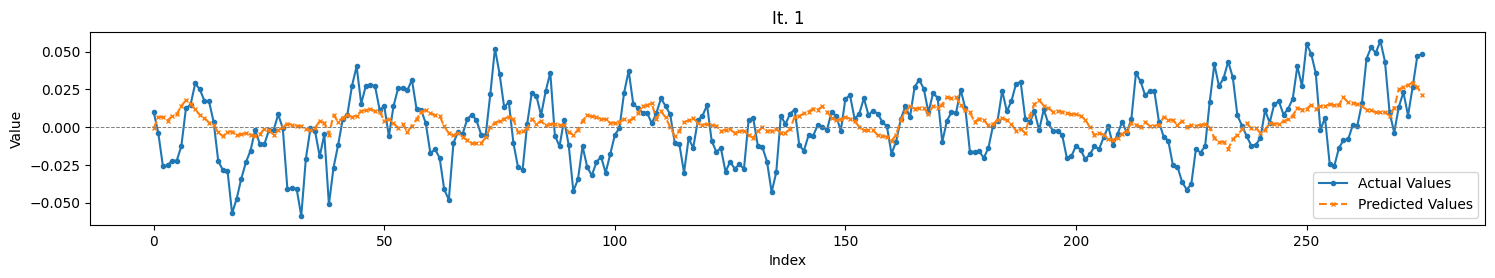

Completed Iteration 1/18

Iteration 2/18
Params: n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 25)            3600      
                                                                 
 lstm_3 (LSTM)               (None, 25)                5100      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________________

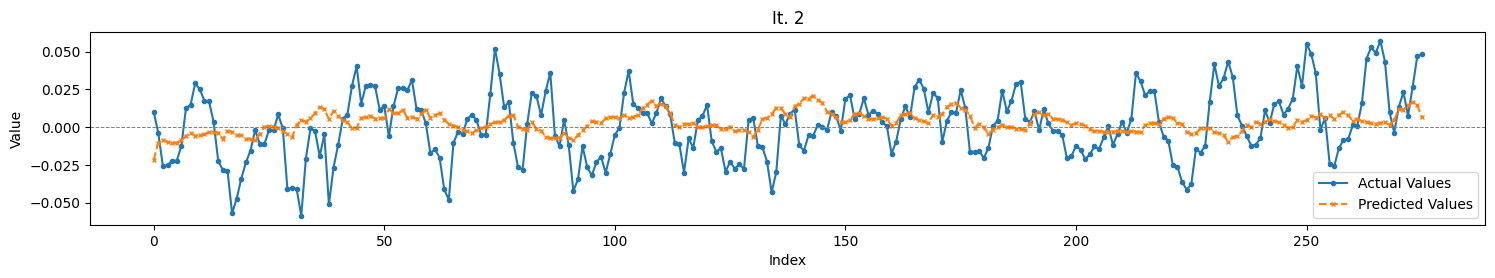

Completed Iteration 2/18

Iteration 3/18
Params: n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40, 25)            3600      
                                                                 
 lstm_5 (LSTM)               (None, 25)                5100      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________

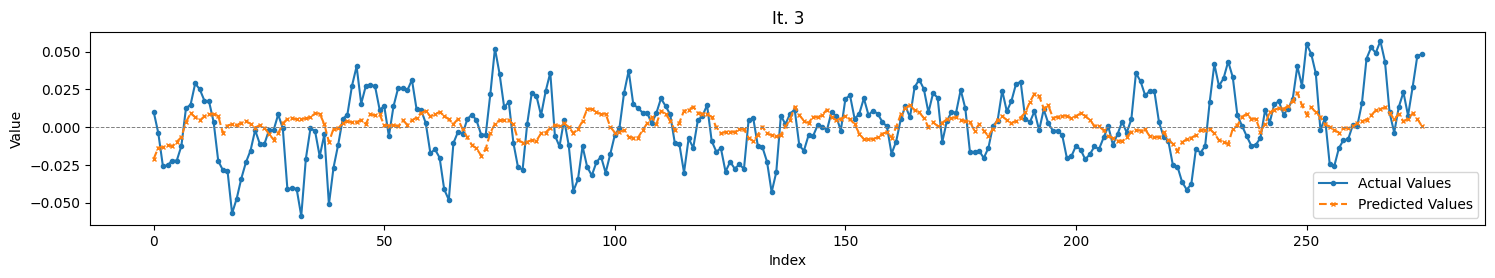

Completed Iteration 3/18

Iteration 4/18
Params: n_steps: 40, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 40, 75)            25800     
                                                                 
 lstm_7 (LSTM)               (None, 75)                45300     
                                                                 
 dense_3 (Dense)             (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

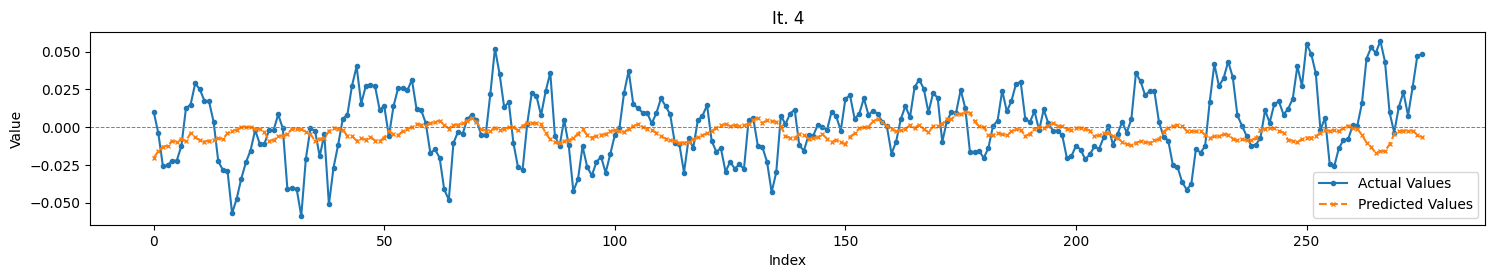

Completed Iteration 4/18

Iteration 5/18
Params: n_steps: 40, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 40, 75)            25800     
                                                                 
 lstm_9 (LSTM)               (None, 75)                45300     
                                                                 
 dense_4 (Dense)             (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

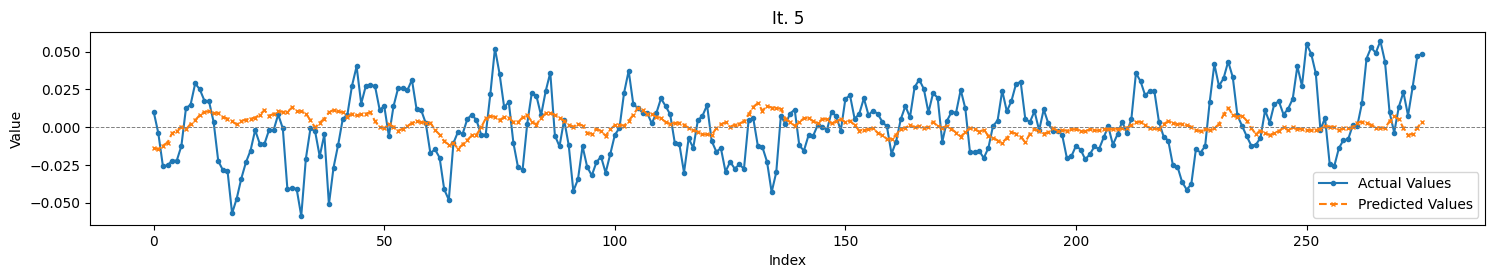

Completed Iteration 5/18

Iteration 6/18
Params: n_steps: 40, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 40, 75)            25800     
                                                                 
 lstm_11 (LSTM)              (None, 75)                45300     
                                                                 
 dense_5 (Dense)             (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________

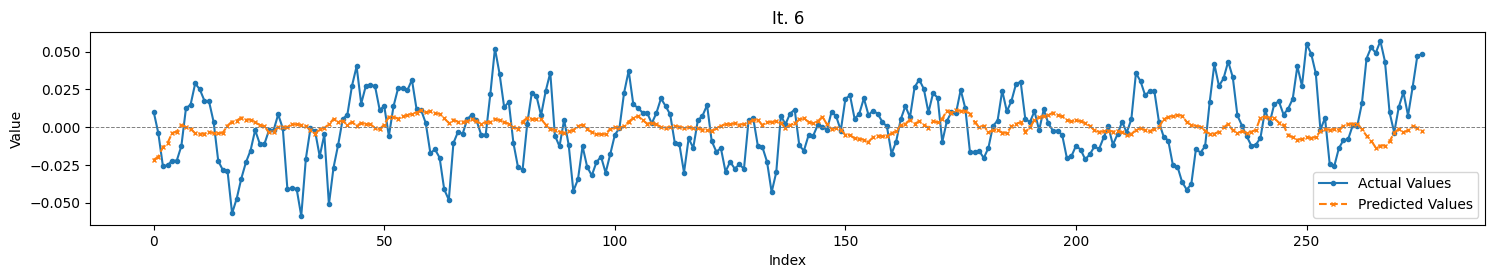

Completed Iteration 6/18

Iteration 7/18
Params: n_steps: 60, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 25)            3600      
                                                                 
 lstm_13 (LSTM)              (None, 25)                5100      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________________

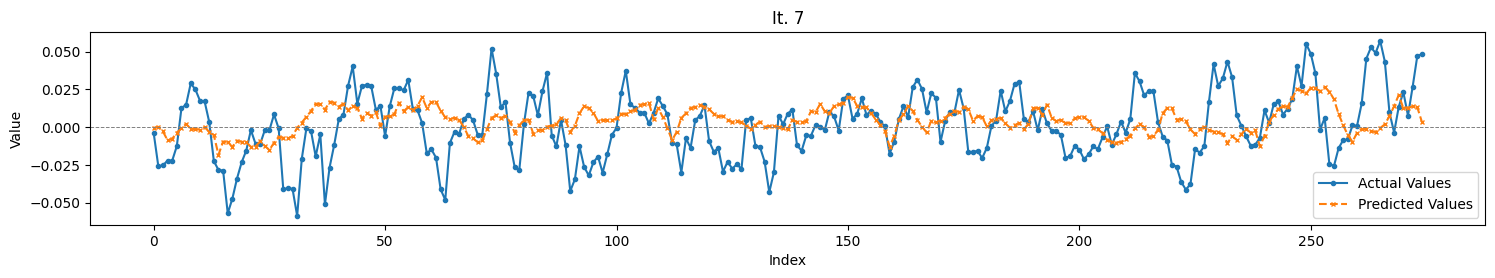

Completed Iteration 7/18

Iteration 8/18
Params: n_steps: 60, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 25)            3600      
                                                                 
 lstm_15 (LSTM)              (None, 25)                5100      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________________

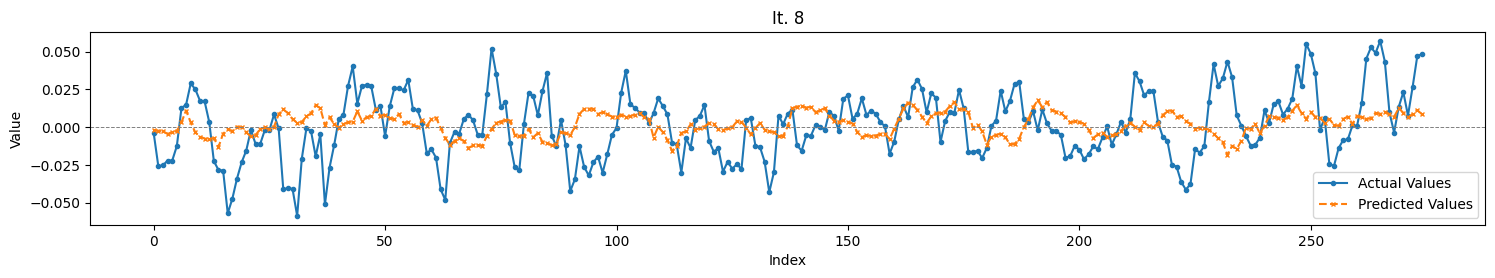

Completed Iteration 8/18

Iteration 9/18
Params: n_steps: 60, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 25)            3600      
                                                                 
 lstm_17 (LSTM)              (None, 25)                5100      
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________

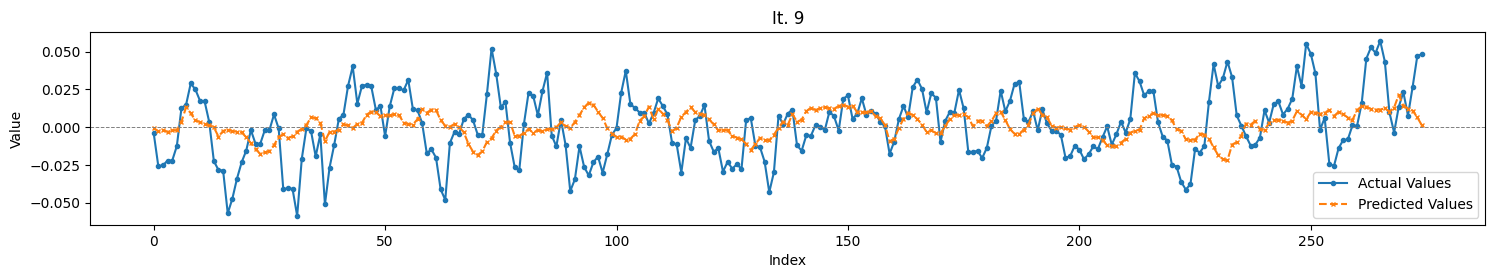

Completed Iteration 9/18

Iteration 10/18
Params: n_steps: 60, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 60, 75)            25800     
                                                                 
 lstm_19 (LSTM)              (None, 75)                45300     
                                                                 
 dense_9 (Dense)             (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________

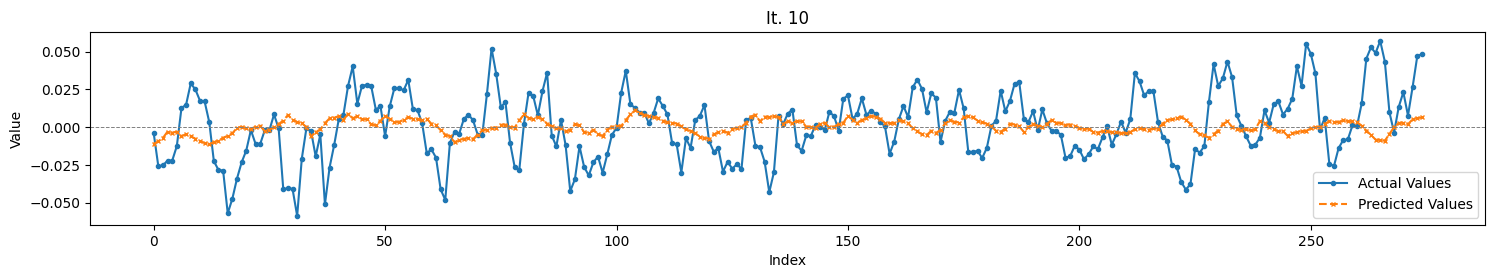

Completed Iteration 10/18

Iteration 11/18
Params: n_steps: 60, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 60, 75)            25800     
                                                                 
 lstm_21 (LSTM)              (None, 75)                45300     
                                                                 
 dense_10 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________

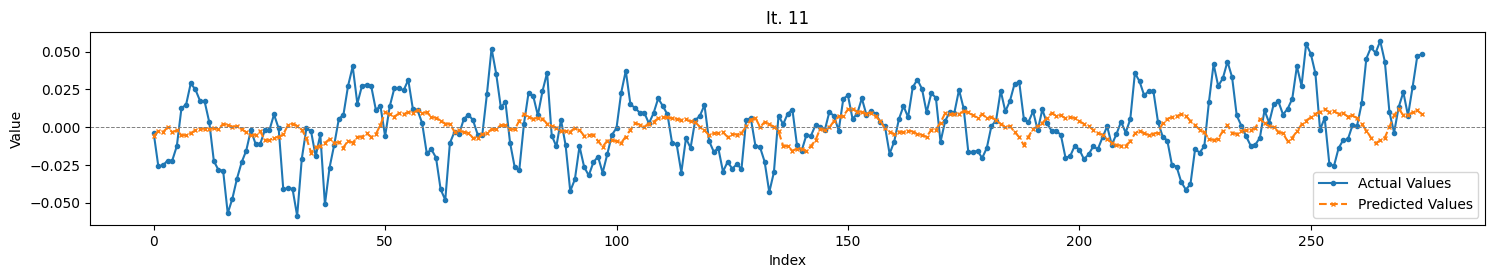

Completed Iteration 11/18

Iteration 12/18
Params: n_steps: 60, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 60, 75)            25800     
                                                                 
 lstm_23 (LSTM)              (None, 75)                45300     
                                                                 
 dense_11 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________

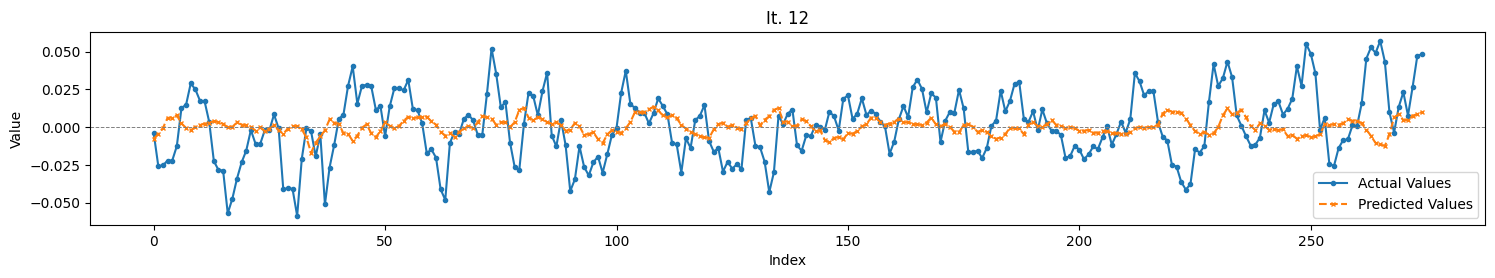

Completed Iteration 12/18

Iteration 13/18
Params: n_steps: 120, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 120, 25)           3600      
                                                                 
 lstm_25 (LSTM)              (None, 25)                5100      
                                                                 
 dense_12 (Dense)            (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________

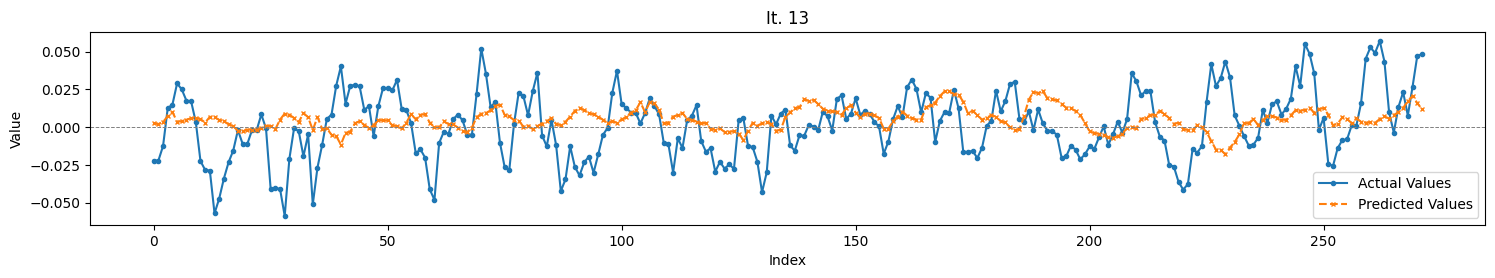

Completed Iteration 13/18

Iteration 14/18
Params: n_steps: 120, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 120, 25)           3600      
                                                                 
 lstm_27 (LSTM)              (None, 25)                5100      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________

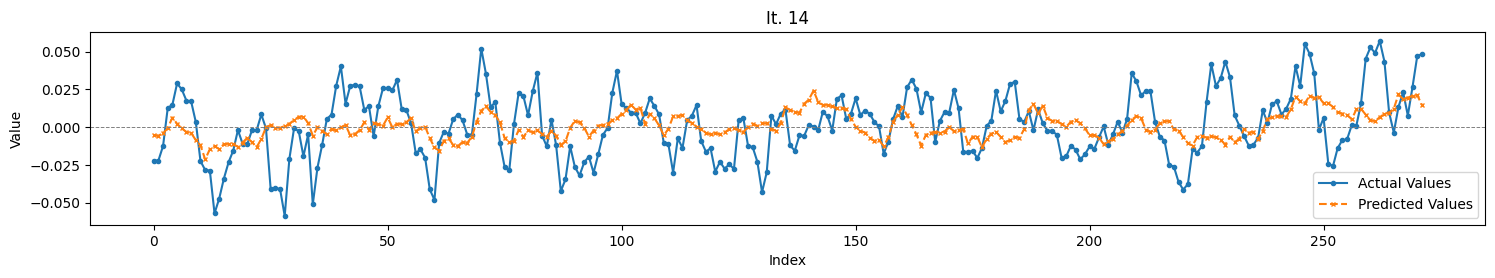

Completed Iteration 14/18

Iteration 15/18
Params: n_steps: 120, lstm_units: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 120, 25)           3600      
                                                                 
 lstm_29 (LSTM)              (None, 25)                5100      
                                                                 
 dense_14 (Dense)            (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

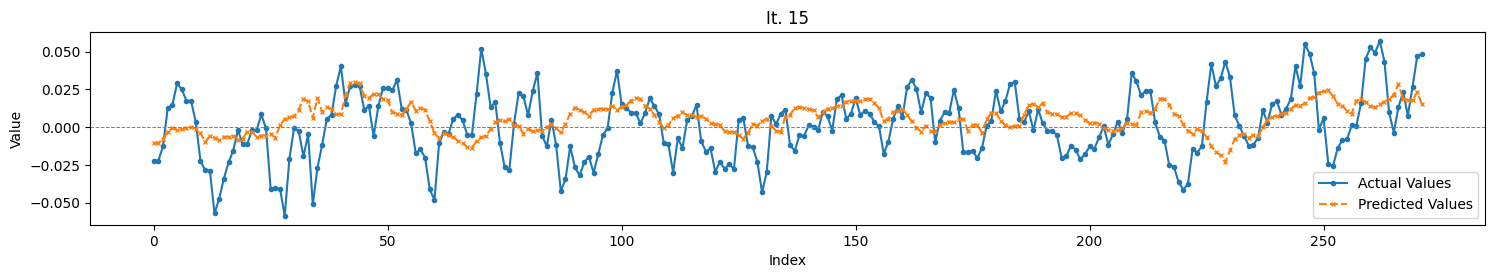

Completed Iteration 15/18

Iteration 16/18
Params: n_steps: 120, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 120, 75)           25800     
                                                                 
 lstm_31 (LSTM)              (None, 75)                45300     
                                                                 
 dense_15 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________

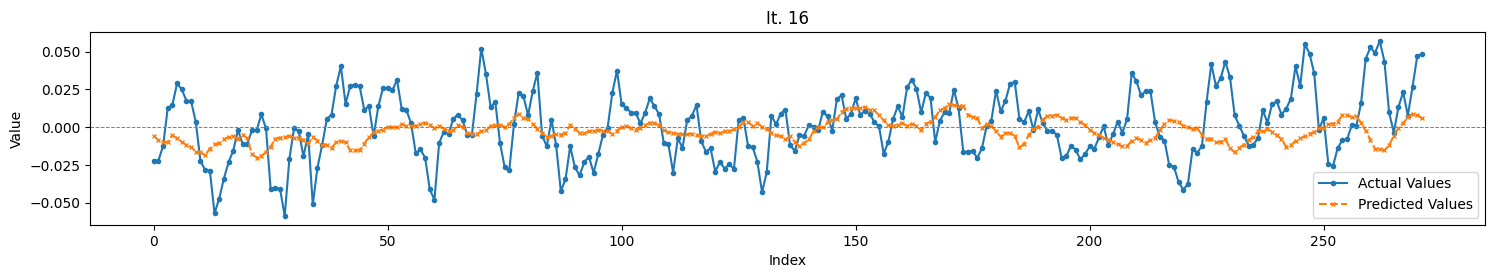

Completed Iteration 16/18

Iteration 17/18
Params: n_steps: 120, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 120, 75)           25800     
                                                                 
 lstm_33 (LSTM)              (None, 75)                45300     
                                                                 
 dense_16 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________

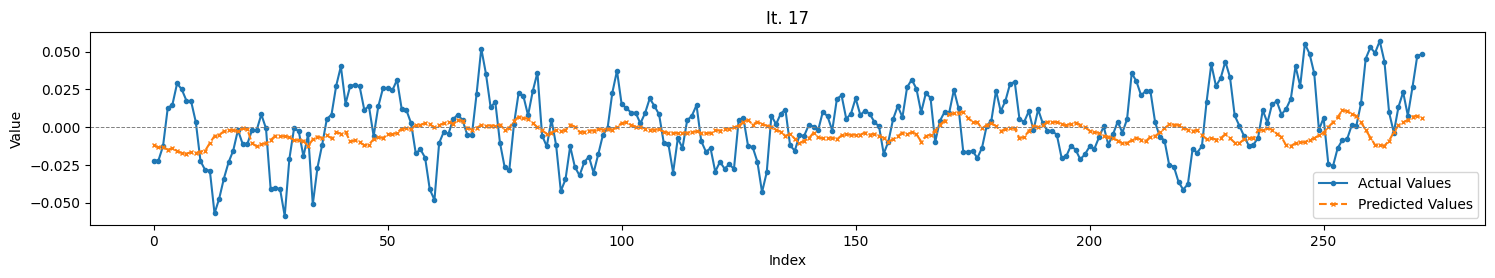

Completed Iteration 17/18

Iteration 18/18
Params: n_steps: 120, lstm_units: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 120, 75)           25800     
                                                                 
 lstm_35 (LSTM)              (None, 75)                45300     
                                                                 
 dense_17 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

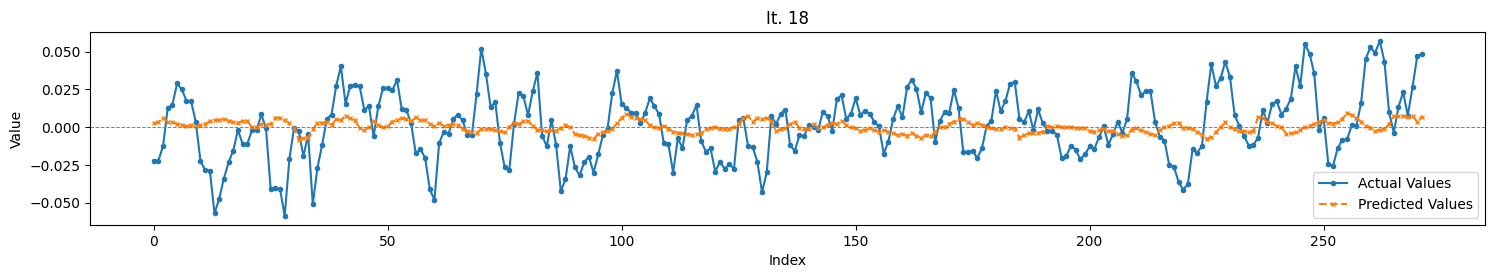

Completed Iteration 18/18


In [18]:
top_results = run_model_iterations()

In [19]:
top_results_sort = sorted(top_results, key=lambda x: x['diff'])[:15]

Top 1 
RMSE: 0.020720, STD_DEV: 0.022002, STD_PRD: 0.008572, OBJDIFF: 0.002076, RDIFF: -0.001281
n_steps: 120, lstm_units: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023706, inv. diff> 0.008419
Trend accuracy       : 58.672
Trend up accuracy    : 55.862
Trend down accuracy  : 61.905


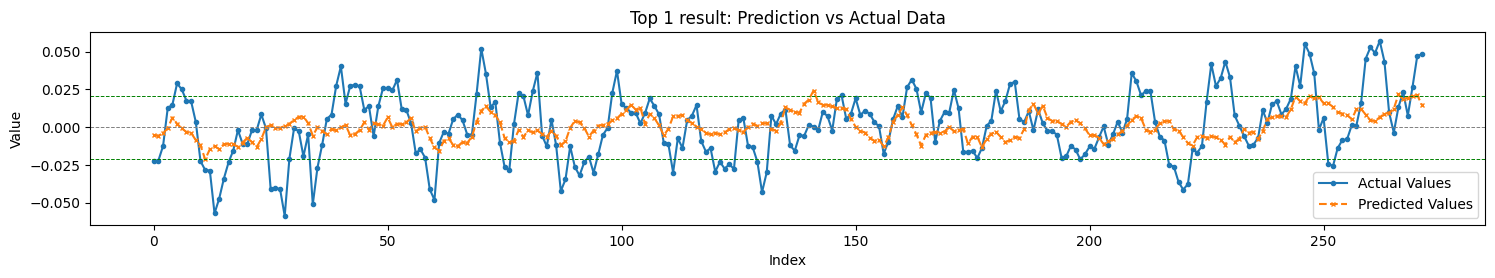

Top 2 
RMSE: 0.021396, STD_DEV: 0.021968, STD_PRD: 0.007593, OBJDIFF: 0.003022, RDIFF: -0.000572
n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023853, inv. diff> 0.009073
Trend accuracy       : 59.273
Trend up accuracy    : 76.712
Trend down accuracy  : 39.535


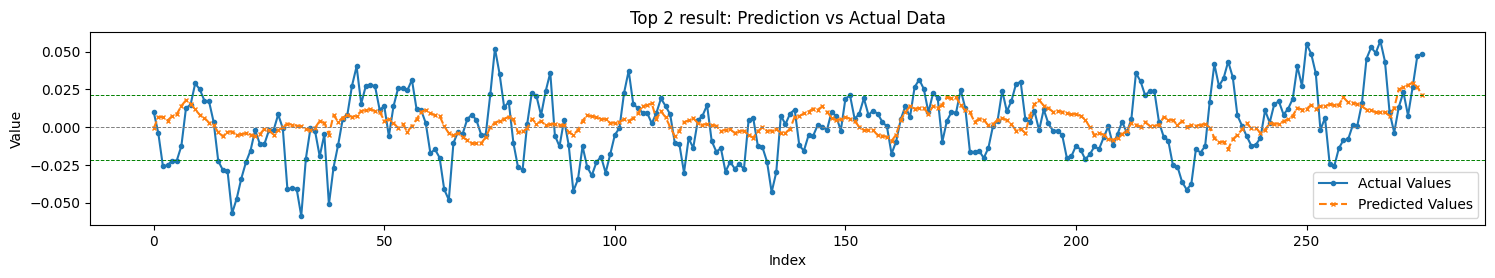

Top 3 
RMSE: 0.021914, STD_DEV: 0.022002, STD_PRD: 0.007976, OBJDIFF: 0.003419, RDIFF: -0.000087
n_steps: 60, lstm_units: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023563, inv. diff> 0.008574
Trend accuracy       : 63.139
Trend up accuracy    : 69.655
Trend down accuracy  : 55.814


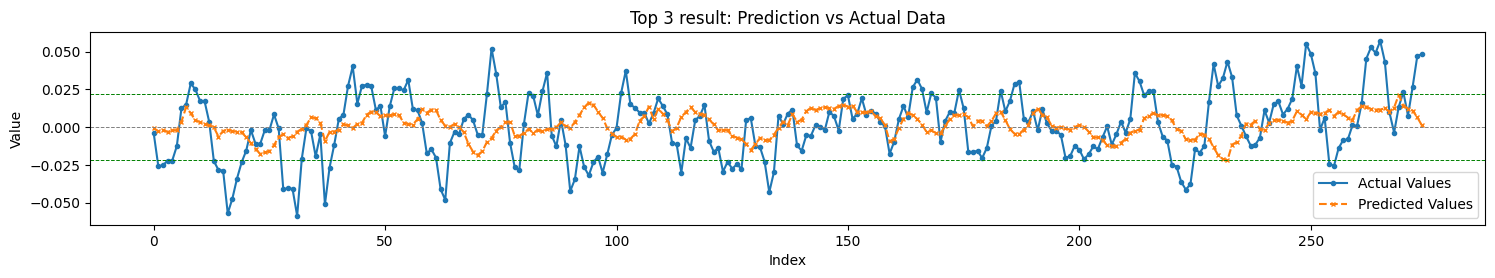

Top 4 
RMSE: 0.021730, STD_DEV: 0.021968, STD_PRD: 0.007309, OBJDIFF: 0.003427, RDIFF: -0.000238
n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023367, inv. diff> 0.008729
Trend accuracy       : 58.909
Trend up accuracy    : 70.548
Trend down accuracy  : 45.736


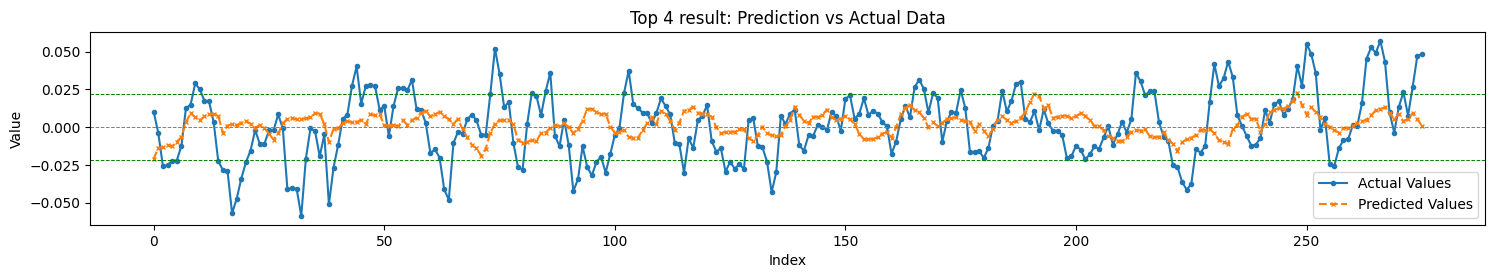

Top 5 
RMSE: 0.021968, STD_DEV: 0.021968, STD_PRD: 0.006441, OBJDIFF: 0.003881, RDIFF: -0.000001
n_steps: 40, lstm_units: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023266, inv. diff> 0.009062
Trend accuracy       : 56.364
Trend up accuracy    : 71.918
Trend down accuracy  : 38.760


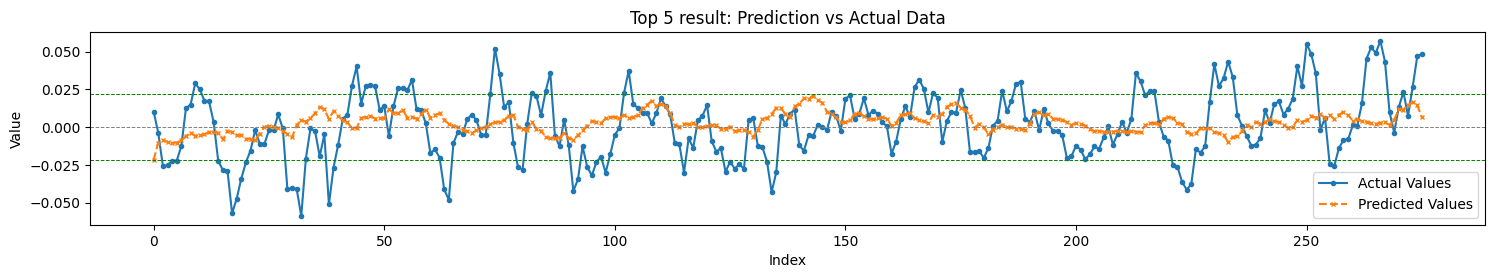

Top 6 
RMSE: 0.022615, STD_DEV: 0.022002, STD_PRD: 0.009562, OBJDIFF: 0.006833, RDIFF: 0.000614
n_steps: 120, lstm_units: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.025047, inv. diff> 0.009265
Trend accuracy       : 57.196
Trend up accuracy    : 74.483
Trend down accuracy  : 37.302


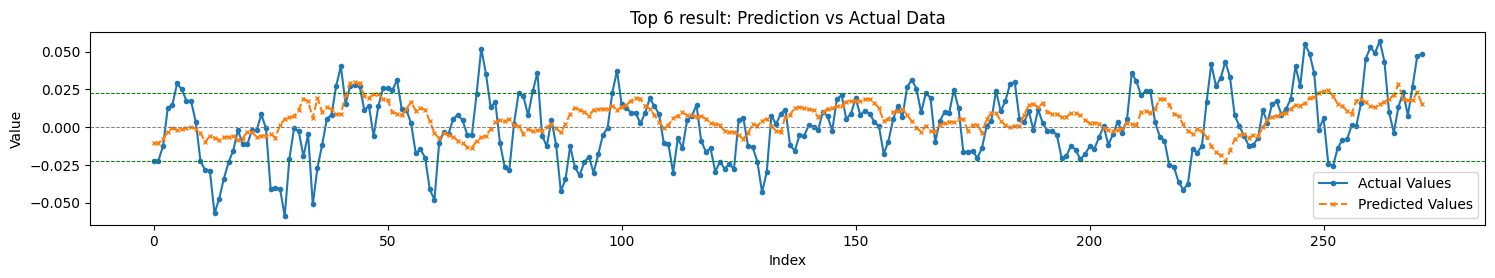

Top 7 
RMSE: 0.022199, STD_DEV: 0.022002, STD_PRD: 0.008673, OBJDIFF: 0.006861, RDIFF: 0.000197
n_steps: 60, lstm_units: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024274, inv. diff> 0.008937
Trend accuracy       : 53.650
Trend up accuracy    : 70.345
Trend down accuracy  : 34.884


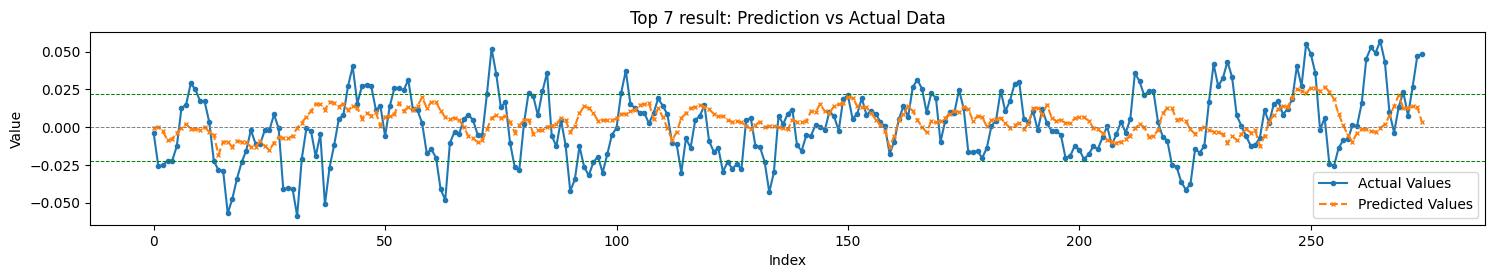

Top 8 
RMSE: 0.022536, STD_DEV: 0.022002, STD_PRD: 0.007257, OBJDIFF: 0.007906, RDIFF: 0.000534
n_steps: 60, lstm_units: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023372, inv. diff> 0.008743
Trend accuracy       : 55.839
Trend up accuracy    : 64.828
Trend down accuracy  : 45.736


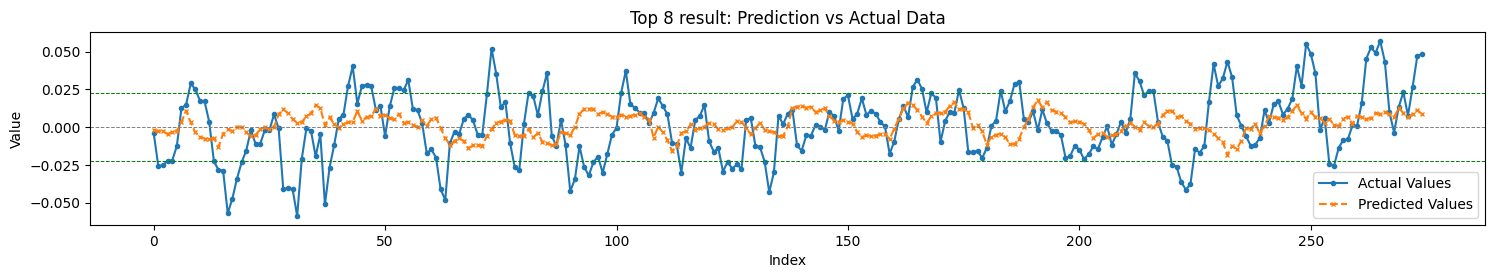

Top 9 
RMSE: 0.023235, STD_DEV: 0.022002, STD_PRD: 0.007015, OBJDIFF: 0.008727, RDIFF: 0.001233
n_steps: 120, lstm_units: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024024, inv. diff> 0.009515
Trend accuracy       : 52.768
Trend up accuracy    : 78.621
Trend down accuracy  : 23.016


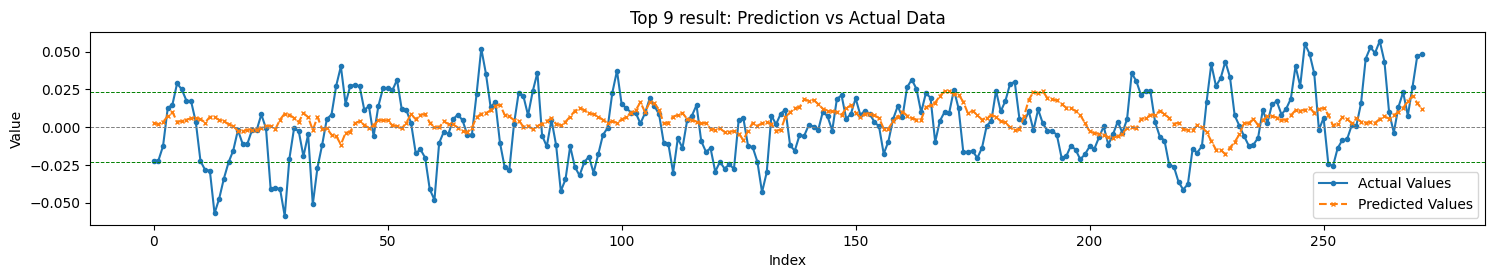

Top 10 
RMSE: 0.023120, STD_DEV: 0.022002, STD_PRD: 0.006623, OBJDIFF: 0.008808, RDIFF: 0.001119
n_steps: 60, lstm_units: 75, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022994, inv. diff> 0.008682
Trend accuracy       : 50.365
Trend up accuracy    : 46.897
Trend down accuracy  : 54.264


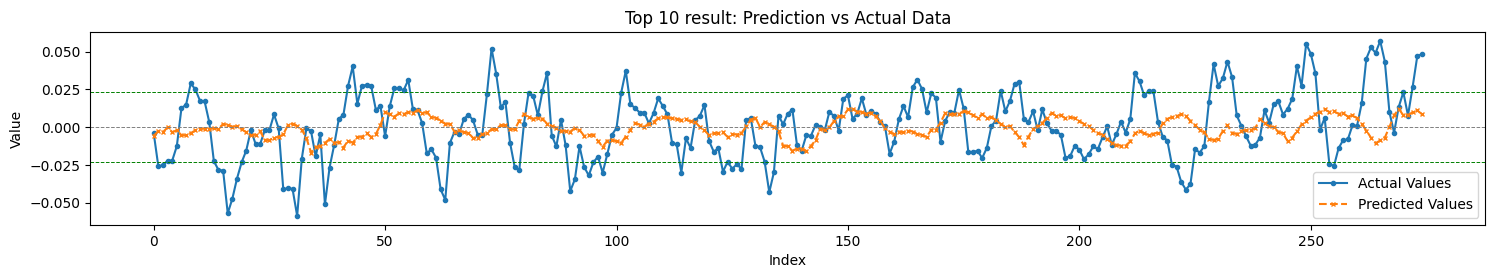

Top 11 
RMSE: 0.022646, STD_DEV: 0.021968, STD_PRD: 0.005567, OBJDIFF: 0.008878, RDIFF: 0.000677
n_steps: 40, lstm_units: 75, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022821, inv. diff> 0.009054
Trend accuracy       : 50.909
Trend up accuracy    : 56.164
Trend down accuracy  : 44.961


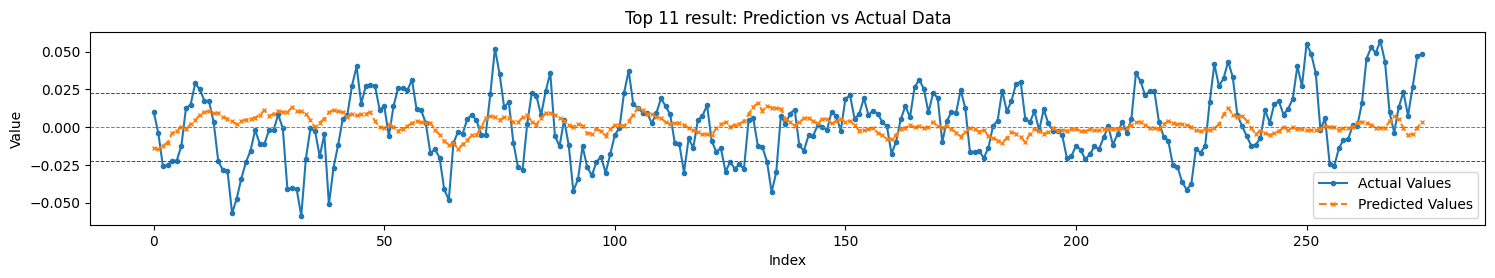

Top 12 
RMSE: 0.022417, STD_DEV: 0.022002, STD_PRD: 0.004533, OBJDIFF: 0.009150, RDIFF: 0.000416
n_steps: 60, lstm_units: 75, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022526, inv. diff> 0.009258
Trend accuracy       : 53.650
Trend up accuracy    : 59.310
Trend down accuracy  : 47.287


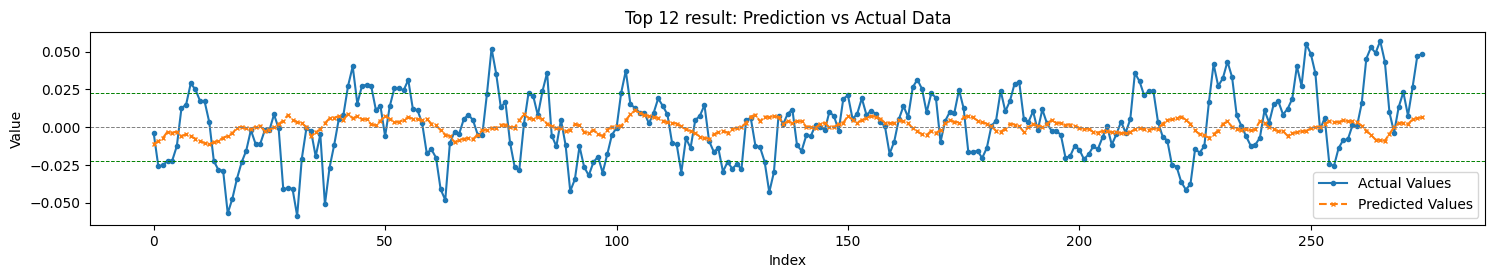

Top 13 
RMSE: 0.023716, STD_DEV: 0.022002, STD_PRD: 0.007092, OBJDIFF: 0.009170, RDIFF: 0.001715
n_steps: 120, lstm_units: 75, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023150, inv. diff> 0.008604
Trend accuracy       : 52.399
Trend up accuracy    : 37.931
Trend down accuracy  : 69.048


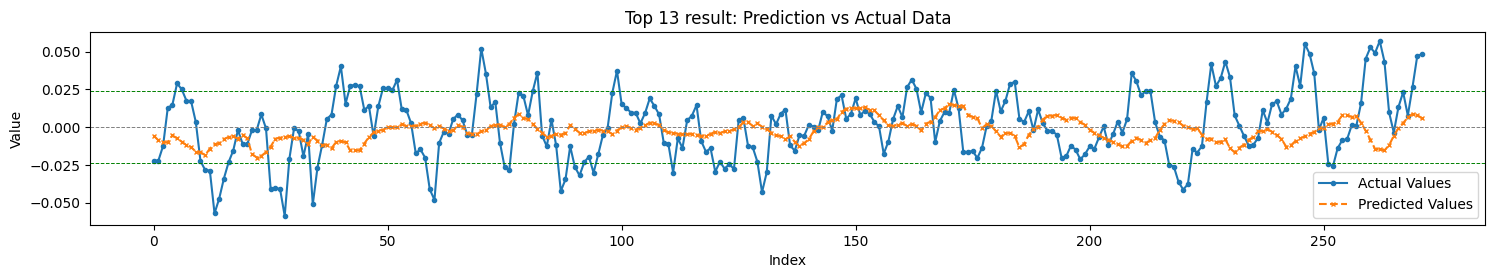

Top 14 
RMSE: 0.022896, STD_DEV: 0.022002, STD_PRD: 0.005189, OBJDIFF: 0.009301, RDIFF: 0.000895
n_steps: 60, lstm_units: 75, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022678, inv. diff> 0.009082
Trend accuracy       : 52.555
Trend up accuracy    : 58.621
Trend down accuracy  : 45.736


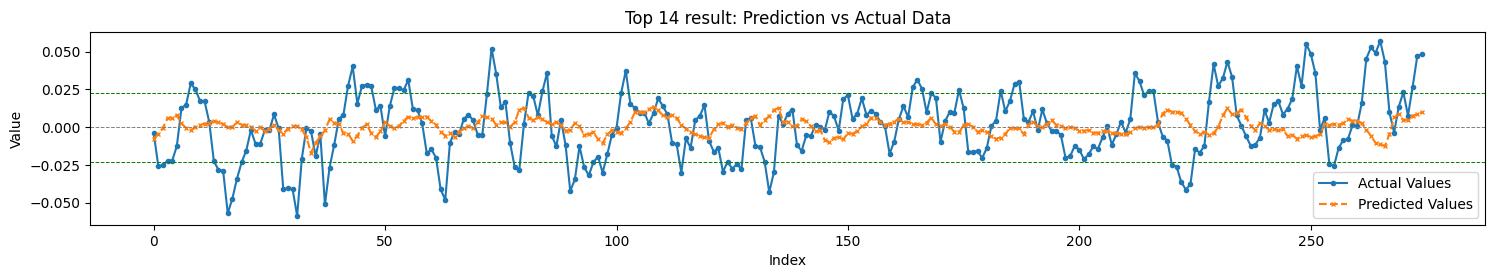

Top 15 
RMSE: 0.022562, STD_DEV: 0.022002, STD_PRD: 0.003696, OBJDIFF: 0.009714, RDIFF: 0.000561
n_steps: 120, lstm_units: 75, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022384, inv. diff> 0.009535
Trend accuracy       : 48.339
Trend up accuracy    : 48.966
Trend down accuracy  : 47.619


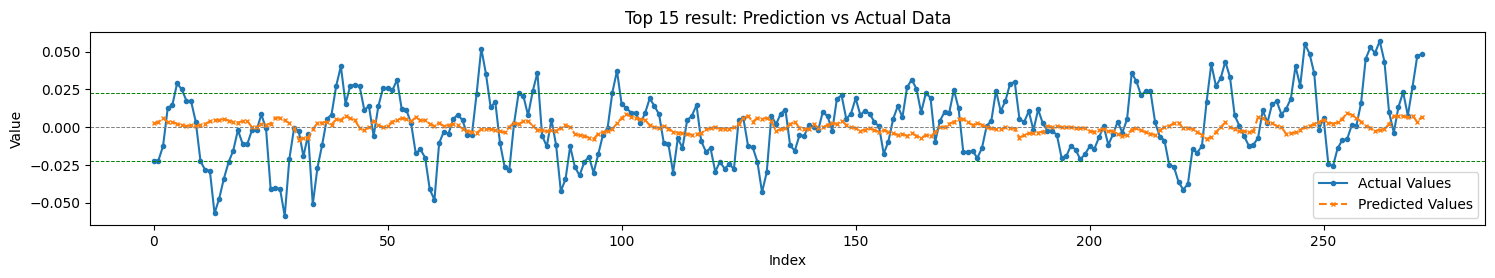

In [25]:
for i,result in enumerate(top_results_sort,1):
    print(f"Top {i} ")
    
    # if (result['rmse']<result['std_dev']):
    #     result['diff'] = result['rmse']-result['std_dev'] + abs(np.std(result['predictions']) - result['std_dev'])/4.0
    # else:
    #     result['diff'] = (result['rmse']- result['std_dev']) + abs(np.std(result['predictions']) - result['std_dev'])/2.0

    print("RMSE: {:.6f}, STD_DEV: {:.6f}, STD_PRD: {:.6f}, OBJDIFF: {:.6f}, RDIFF: {:.6f}".format(result['rmse'], result['std_dev'], np.std(result['predictions']), result['diff'],result['rmse']-result['std_dev']))
    print("n_steps: {}, lstm_units: {}, activation: {}, dropout: {}, batch_size: {}, epochs: {}".format(result['n_steps'], result['lstm_units'], result['activation'], result['dropout'], result['batch_size'], result['epochs']))
    print("Feature list: ", result['feature_list'])

    # var_tot     = set(variable_options)
    # fea_list    = set(result['feature_list'])
    # print("Discarded var: {}".format(var_tot - fea_list))

    result['inv_rmse'] = inv_rmse = rmse(result['true_values'], result['predictions']*-1)
    inv_diff = (inv_rmse - result['std_dev']) + abs(np.std(result['predictions']) - result['std_dev'])/2.0
    print("Inv. rmse> {:.6f}, inv. diff> {:.6f}".format(inv_rmse, inv_diff))

    # calculate trend prediction percentage

    trend_up_true   = 0
    trend_down_true = 0
    trend_up_pred   = 0
    trend_down_pred = 0

    for j in range(len(result['true_values'])-1):
        if result['true_values'][j] > 0.0:
            trend_up_pred += 1
            if result['predictions'][j] > 0.0:
                trend_up_true += 1
        if result['true_values'][j] < 0.0:
            trend_down_pred += 1
            if result['predictions'][j] < 0.0:
                trend_down_true += 1

    trend_true      = trend_up_true + trend_down_true
    trend_pred      = trend_up_pred + trend_down_pred
    trend_accuracy  = trend_true/trend_pred
    print("Trend accuracy       : {:.3f}".format(trend_accuracy*100))
    print("Trend up accuracy    : {:.3f}".format(trend_up_true*100/trend_up_pred))
    print("Trend down accuracy  : {:.3f}".format(trend_down_true*100/trend_down_pred))

    # plot_predictions(result['true_values'], result['predictions'],250, title=f"Top {i} result: Prediction vs Actual Data")
    plot_predictions(result['true_values'], result['predictions'],-1, title=f"Top {i} result: Prediction vs Actual Data",rmse=result['rmse'])


In [21]:
# export the best result predictions and true values to a csv file
best_result = top_results[0]
best_result_df = pd.DataFrame({'True Values': best_result['true_values'], 'Predictions': best_result['predictions'].flatten()})
best_result_df.to_csv('../output/lstm_best_result.csv', index=False)